# Party Prediction

In [1]:
#Necessary packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [2]:
#Read the data bushfire subset
data = pd.read_csv("data/bushfire_subset.csv")

In [448]:
class MlogitMargins:
    """
    Calculates marginal effect of multinomial logit coefficients with bootstraped confidence interval.
    See https://github.com/alicehwu/gendered_language/blob/master/gendered_language_2018.pdf for a 
    reference on a similar approach but with binary classification.
    """
    def __init__(self, X, y, penalty):
        
        #Define data
        self.vect = CountVectorizer(ngram_range=(1,1), max_features = 10000)
        self.X = self.vect.fit_transform(X)
        self.y = y
        self.penalty = penalty
        print("Fitting model and calculating margins...")
        #Fit model and calculate average marginal effects
        #self.margins2 = self.avg_margins2(self.X, self.y)
        
        self.margins = self.avg_margins(self.X, self.y, self.penalty)
    
    def avg_margins(self, X, y, penalty):
        """
        Calculates average marginal effect of coefficients in multinomial logit model, where each coefficient is 
        a word token and is calculated as:
        avg_margin_jk =  1/N * sum_i{sum{P(y_i = j) * [beta_jk - sum_m(P(y_i = m) 
                         * beta_jm)]} for each token k and class j.
        -----------
        Returns:
            - DataFrame with average margins of shape classes_j * tokens_k
            - The fitted mlogit model 
        """
        #Fit the model
        model = self.fit_model(X, y, penalty)
        #Get probabilities for each obs i belonging to class j. shape =  N * J
        probas = model.predict_proba(X)
        #Get coefficients. Shape j_classes * k_coefficients
        betas = model.coef_
        
        avg_margins = np.zeros([betas.shape[1], betas.shape[0]])
        
        for j in tqdm(range(betas.shape[0])):
            for k in range(betas.shape[1]):
                dydw = 0
                for i in range(probas.shape[0]):
                    dydw += probas[i,j] * (betas[j,k] - np.dot(probas[i,:],betas[:,k]))
                avg_margins[k,j] = 1 / probas.shape[0] * dydw
       
        #Extract the token name corresponding to the avg margins   
        margins_df = pd.DataFrame(avg_margins, columns=model.classes_)
        margins_df["token"] = self.vect.get_feature_names()
        
        return margins_df, model
    
    def avg_margins2(self, X, y, penalty):
        """
        Calculates average marginal effect of coefficients in multinomial logit model, where each coefficient is 
        a word token and is calculated as:
        avg_margin_jk =  1/N * sum_i{sum{P(y_i = j) * [beta_jk - sum_m(P(y_i = m) 
                         * beta_jm)]} for each token k and class j.
        -----------
        Returns:
            - DataFrame with average margins of shape classes_j * tokens_k
            - The fitted mlogit model 
        """
        #Fit the model
        model = self.fit_model(X, y, penalty)
        #Get probabilities for each obs i belonging to class j. shape = j * N
        probas = model.predict_proba(X)
        #Get coefficients. Shape j_classes * k_coefficients
        betas = model.coef_
        
        tst = np.einsum('ij,jk->k', probas, betas)
        #avg_margins = 1 / probas.shape[0] * np.einsum('ij,jk->ik',probas, (betas - np.einsum('ij,jk->k', probas, betas)))
        
        
        #margins_df = pd.DataFrame(avg_margins, columns=model.classes_)
        #margins_df["token"] = self.vect.get_feature_names()
        
        return tst, betas
    
    def fit_model(self, X, y, penalty, max_iter = 1000, class_weight = "balanced",
                            verbose = False, fit_intercept = True, multi_class = "multinomial",
                            C = 1):
        
        """
        Fits sklearn multinomial logistic model on data.
        """

        mlogit = LogisticRegression(random_state=42, penalty=penalty, solver="saga", 
                                   max_iter = max_iter, class_weight = class_weight,
                                   fit_intercept=fit_intercept, multi_class=multi_class,
                                   verbose=verbose, C = C).fit(X, y)  

        return mlogit
    
    def bootstrap_ci(self, alpha = 0.05, n_samples = 500, sample_prop = 0.4):
        """
        Uses bootstraping to calculate confidence interval around average marginal effects estimate.
        -------------
        Arguments:
            - alpha: deterimines confidence level of the interval
            - n_samples: amount of bootstrap samples
            - sample_prop: bootstramp sample size as proportion of original sample
        -------------
        Return:
            - Pandas dataframe with confidence interval for average marginal effect
              of each coefficient.
        """
        statistics = [] #List for bootstrap results
        
        #Define the bootstrap sample size based on proportion of total
        n_size = int(self.X.shape[0] * sample_prop)
        print(f"Number of obs in bootstrap samples {n_size}...")
        start = time.time()
        for i in tqdm(range(n_samples)):
            #Draw random sample from X and y with replacement
            idx = np.random.choice(np.arange(self.X.shape[0]), n_size, replace=True)
            X_sample = self.X[idx]
            y_sample = self.y[idx]
            #Calculate marginal effect for sample
            margins = self.avg_margins(X_sample, y_sample)[0]
            statistics.append(margins)
        
        #Join the resulting dataframes of margins
        statistics = pd.concat(statistics)
        print(f"Boostraping Done. Calculating {1-alpha}% confidence interval...")
        #From bootstrap results get lower and upper CI limits based on alpha
        statistics = statistics.groupby("token").quantile([alpha, 1-alpha]).reset_index()        
        print("Time to complete: ", time.time() - start)

        return statistics
    

In [ ]:
#define X and y
logit_data = data.loc[~data["party"].isin(["Katter's Australian Party", "Centre Alliance", "Liberal National Party of Queensland"])]

X, y = logit_data["final_text"], logit_data["party"]
mlogit = MlogitMargins(X, y)

In [417]:
print(mlogit.margins[0].round(2).sort_values("Liberal Party of Australia", ascending=False).head(10).to_markdown())

|      |   Australian Greens |   Australian Labor Party |   Liberal Party of Australia |   The Nationals | token     |
|-----:|--------------------:|-------------------------:|-----------------------------:|----------------:|:----------|
| 2206 |               -0.03 |                    -0.16 |                         0.23 |           -0.05 | ensur     |
| 5237 |               -0.03 |                    -0.16 |                         0.23 |           -0.05 | network   |
| 1645 |               -0.03 |                    -0.14 |                         0.22 |           -0.05 | courag    |
| 3661 |               -0.02 |                    -0.12 |                         0.18 |           -0.04 | join      |
| 8447 |               -0.01 |                    -0.17 |                         0.18 |            0    | spoke     |
|  108 |               -0.02 |                    -0.12 |                         0.18 |           -0.04 | addit     |
| 2983 |               -0.02 |                  

In [449]:
noregres = MlogitMargins(X, y, penalty="none")
l1res = MlogitMargins(X, y, penalty="l1")
l2res = MlogitMargins(X, y, penalty="l2")

Fitting model and calculating margins...


/home/matiasp/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
100%|██████████| 4/4 [04:25<00:00, 66.41s/it]


Fitting model and calculating margins...


/home/matiasp/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
100%|██████████| 4/4 [04:01<00:00, 60.48s/it]


Fitting model and calculating margins...


100%|██████████| 4/4 [04:17<00:00, 64.38s/it]


In [450]:
l1plot = l1res.margins[0].melt(id_vars=["token"])
l2plot = l2res.margins[0].melt(id_vars=["token"])
noneplot = noregres.margins[0].melt(id_vars=["token"])

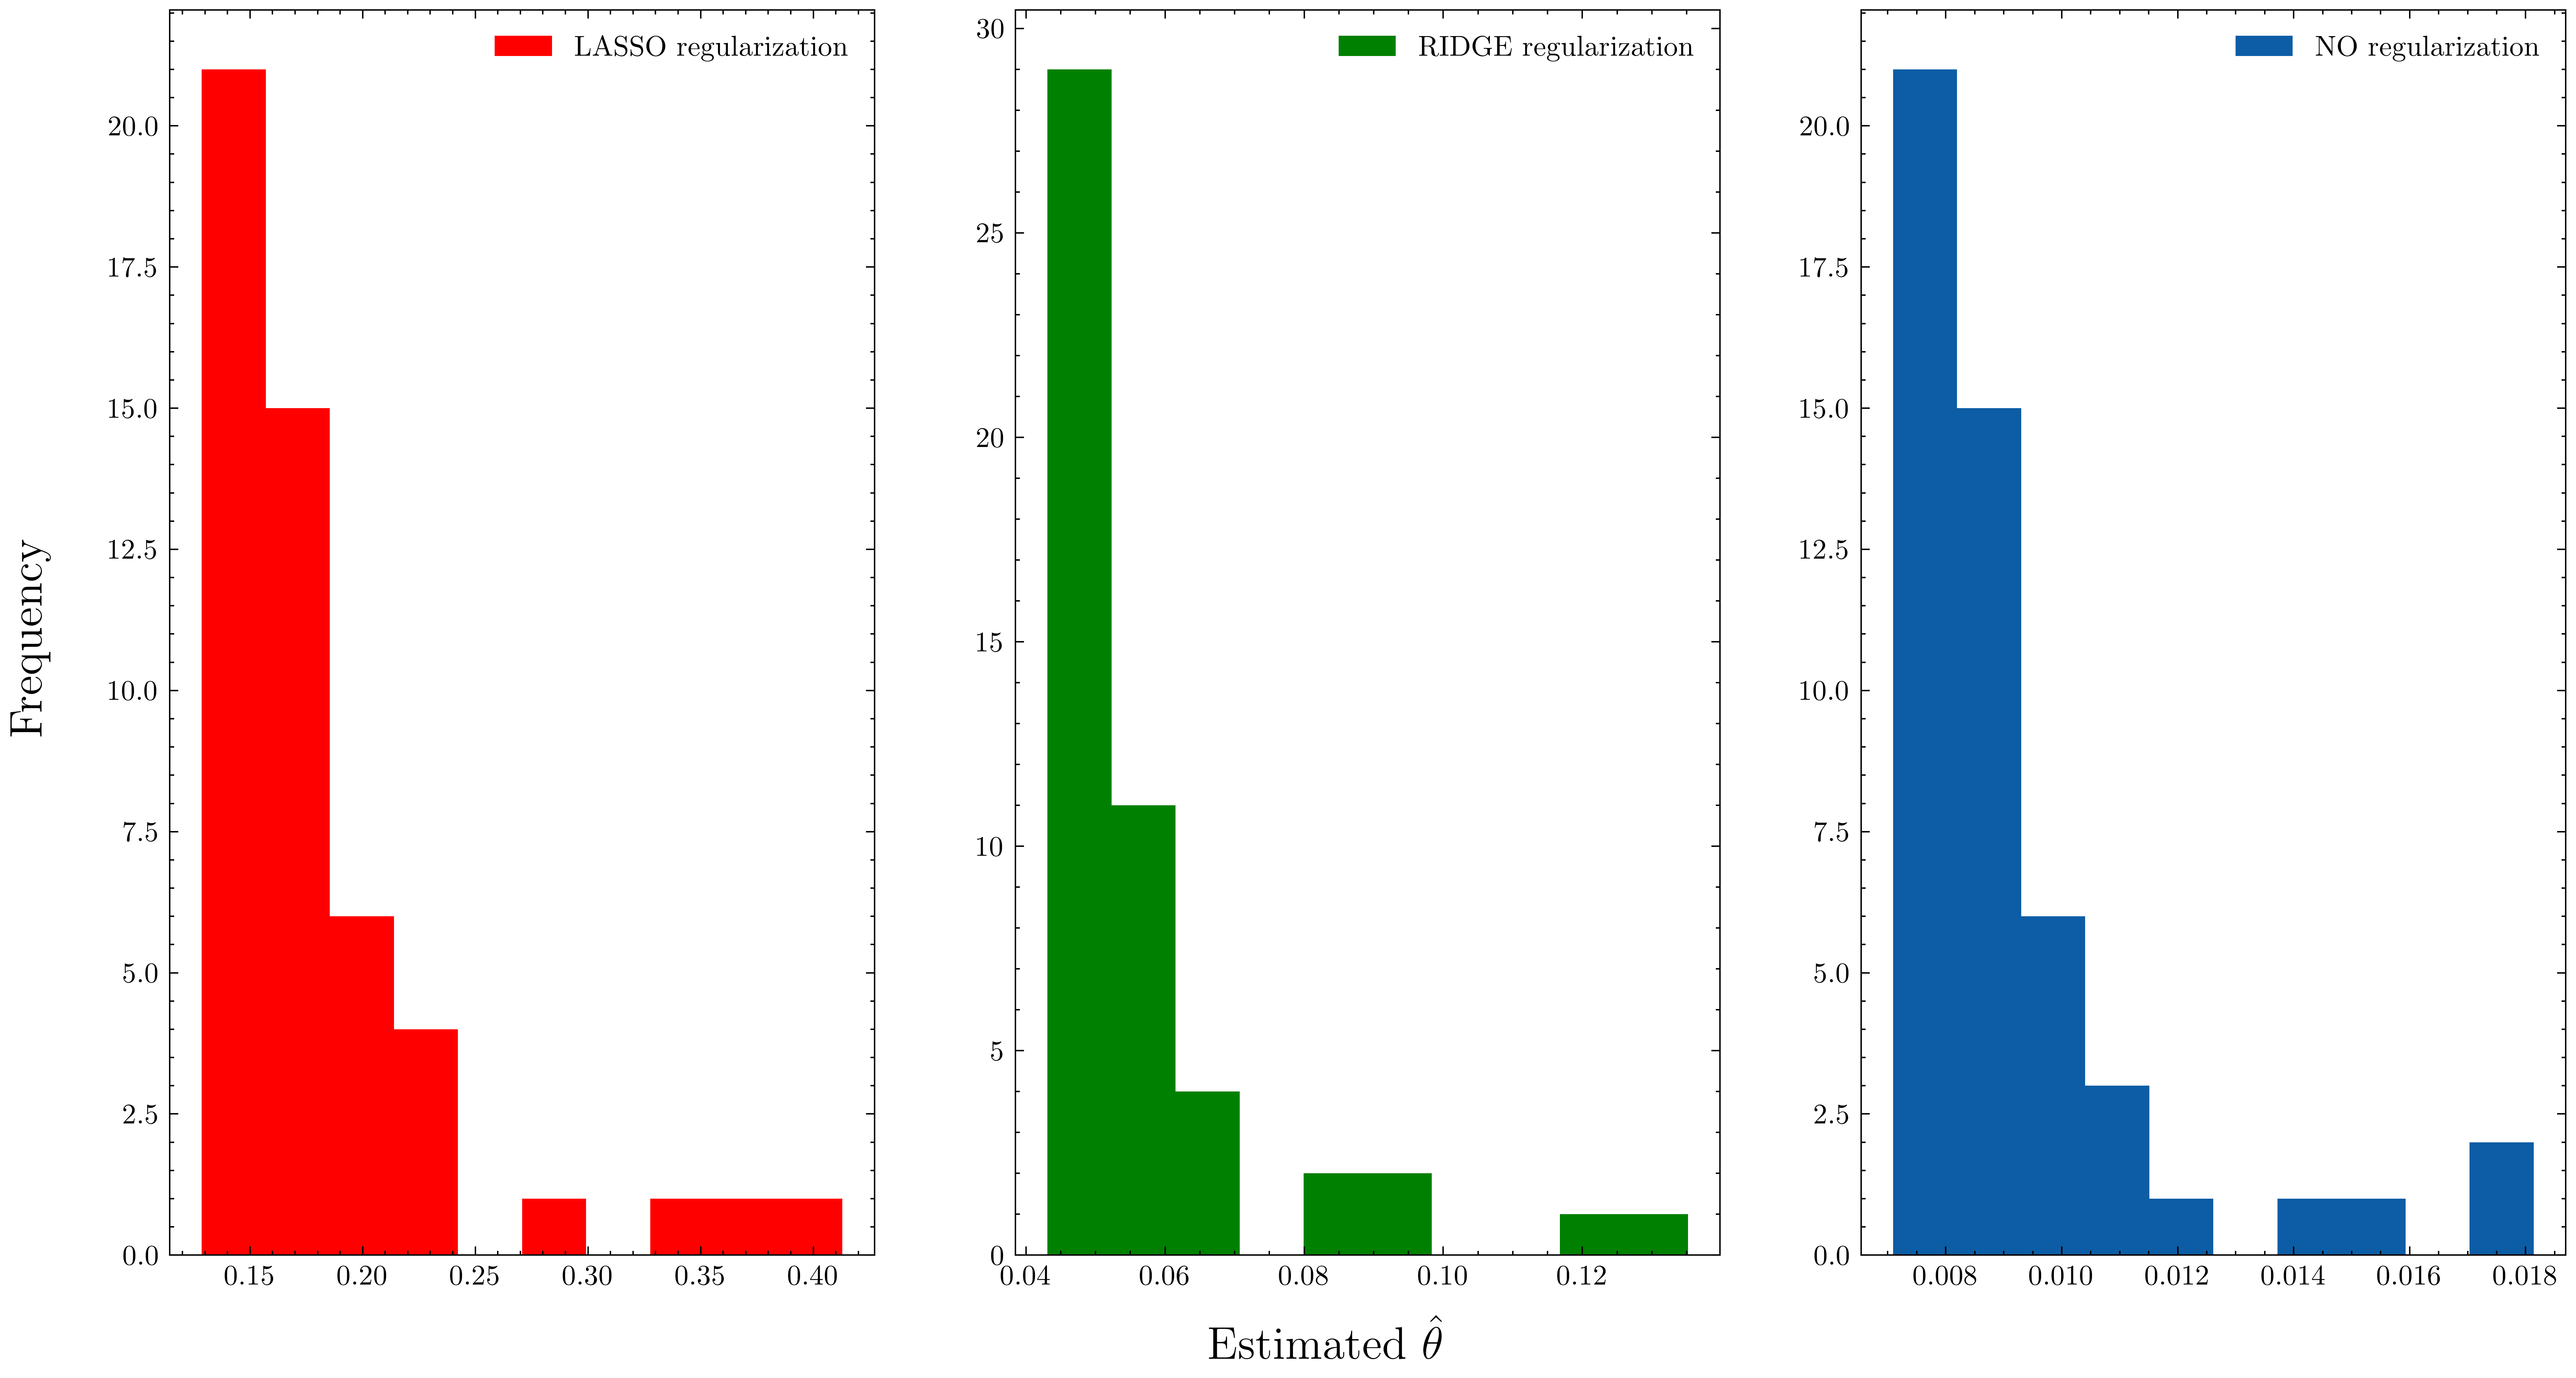

In [480]:
with plt.style.context(['science']):
    fig, axs = plt.subplots(1,3, figsize=(15,8), dpi = 600)
    axs[0].hist(l1plot["value"].sort_values(ascending=False).head(50), color = "r", label = "LASSO regularization")
    axs[0].legend()
    axs[1].hist(l2plot["value"].sort_values(ascending=False).head(50), color = "g", label = "RIDGE regularization")
    axs[1].legend()
    axs[2].hist(noneplot["value"].sort_values(ascending=False).head(50), label = "NO regularization")
    axs[2].legend()
    fig.text(0.5,0.07, r"Estimated $\hat{\theta}$", ha="center", va="center", size = 16)
    fig.text(0.08,0.5, "Frequency", ha="center", va="center", rotation=90, size = 16)
    plt.savefig("theta_plot.png")
    plt.show()

In [491]:
l1plot.groupby("variable")["value"].count().sort_values(ascending=False)

variable
Australian Greens             10000
Australian Labor Party        10000
Liberal Party of Australia    10000
The Nationals                 10000
Name: value, dtype: int64

In [499]:
l1plot

,token,variable,value
0,_affect,Australian Greens,0.00000
1,_breakfast,Australian Greens,0.00000
2,_bushfir,Australian Greens,0.02444
3,_by,Australian Greens,0.00000
4,_check,Australian Greens,0.00000
...,...,...,...
39995,zone,The Nationals,0.00000
39996,zone_busi,The Nationals,0.00000
39997,zone_leav,The Nationals,0.00000
39998,zone_photo,The Nationals,0.00000


In [513]:
x1 = l1plot.sort_values("value",ascending=False).head(1000).sort_values("token")
x2 = noneplot.sort_values("value",ascending=False).head(1000).sort_values("token")
x1["rank"] = [r+1 for r in range(x1.shape[0])]
x2["rank"] = [r+1 for r in range(x2.shape[0])]

In [514]:
#Evaluate correlation between non-penalized and lasso
from scipy.stats import pearsonr

pearsonr(x1["rank"], x2["rank"])

(0.9999999999999998, 0.0)

In [496]:
x1

15251    0.412903
39157    0.356631
34052    0.330563
19259    0.293795
25237    0.233979
           ...   
30117    0.107338
13672    0.107074
9007     0.106990
27924    0.106839
2277     0.106830
Name: value, Length: 100, dtype: float64

## Placeholder

In [365]:
import statsmodels.api as sm

In [375]:
def model(X, y, max_iter = 1000, penalty = "none", class_weight = "balanced",
                            verbose = False, fit_intercept = True, multi_class = "multinomial",
                            C = 1):
    #Define data
    vect = CountVectorizer(ngram_range=(1,1), max_features = 10000)
    X = vect.fit_transform(X)
    X = np.asarray(X)
    mlogit = sm.MNLogit(X, y)
    return mlogit

In [376]:
tst = model(logit_data["final_text"], logit_data["party"])

TypeError: unhashable type: 'numpy.ndarray'

In [277]:
logit_data = data.loc[~data["party"].isin(["Katter's Australian Party", "Centre Alliance", "Liberal National Party of Queensland"])]

def model(X, y, max_iter = 1000, penalty = "none", class_weight = "balanced",
                            verbose = False, fit_intercept = True, multi_class = "multinomial",
                            C = 1):
    #Define data
    vect = CountVectorizer(ngram_range=(1,1), max_features = 10000)
    X = vect.fit_transform(X)
    mlogit = LogisticRegression(random_state=42, penalty=penalty, solver="saga", 
                               max_iter = max_iter, class_weight = class_weight,
                               fit_intercept=fit_intercept, multi_class=multi_class,
                               verbose=verbose, C = C).fit(X, y)

    #Fit the model
    #Get probabilities for each obs i belonging to class j. shape = j * N
    probas = mlogit.predict_proba(X)
    #Get coefficients. Shape j_classes * k_coefficients
    betas = mlogit.coef_
    features = vect.get_feature_names()
    return probas, betas, features, mlogit
        
        
probas, betas, features, model = model(logit_data["final_text"], logit_data["party"])

/home/matiasp/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [362]:
dydw = np.zeros([betas.shape[1], betas.shape[0]])
for i in range(probas.shape[0]):
    dydw += probas[i,:] * (betas - (np.dot(probas[i,:], betas)).sum())
dydw = 1/probas.shape[0] * dydw  

ValueError: shapes (4,) and (10000,4) not aligned: 4 (dim 0) != 10000 (dim 0)

In [101]:
tst2 = np.einsum('ij,jk->i',probas, betas)

In [346]:
np.dot(probas , betas).sum(axis = 0)#.shape

array([  503.53823426,   321.96320174, -1911.26354467, ...,
        -174.09489236,   439.75394786,   329.66269524])

In [333]:
np.dot(probas, betas).shape

(2658, 10000)

In [334]:
tst2 = (1 / probas.shape[0] * (np.einsum('ij,jk->ij',probas, betas)))

In [345]:
1 / probas.shape[0] * (np.dot(probas, (betas - (np.dot(probas , betas)).sum(axis = 0)))).sum(axis = 0)

array([-503.34879173, -321.84207187, 1910.54448389, ...,  174.0293939 ,
       -439.58850243, -329.53866864])

In [351]:
tstdf = pd.DataFrame(dydw, columns=model.classes_)
tstdf["token"] = features

In [352]:
tstdf.sort_values("Australian Greens", ascending=False).head(10)

,Australian Greens,Australian Labor Party,Liberal Party of Australia,The Nationals,token
0,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,_affect
6670,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prepar_even
6663,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prep_hot
6664,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prepar
6665,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prepar_anoth
6666,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prepar_australia
6667,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prepar_bushfir
6668,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prepar_closur
6669,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prepar_crisi
6671,-2.111581e+06,-2.111581e+06,-2.111581e+06,-2.111581e+06,prepar_f


In [263]:
np.dot(probas, betas - np.dot(probas , betas).sum(axis = 0))

array([[-127.86397372, -115.90657653,  504.21684823, ...,   27.48051651,
         -84.66984889,  -68.27214854],
       [-127.86128315, -115.9036623 ,  504.20488214, ...,   27.47848901,
         -84.66841031,  -68.27107529],
       [-127.85784828, -115.90034675,  504.19248057, ...,   27.47696204,
         -84.66642447,  -68.26954018],
       ...,
       [-127.78298127, -115.81622319,  504.07941045, ...,   27.38829392,
         -84.64758147,  -68.26120771],
       [-127.79093971, -115.82349349,  504.11242779, ...,   27.39002704,
         -84.65293347,  -68.26553809],
       [-127.79064255, -115.82282963,  504.12413738, ...,   27.38735052,
         -84.65418572,  -68.2668585 ]])

In [239]:
betas - np.dot(probas , betas).sum(axis = 1)

ValueError: operands could not be broadcast together with shapes (4,10000) (2658,) 

In [238]:
np.einsum('ij,jk->k',probas, betas)

array([ 127.78489651,  115.82060649, -503.92285552, ...,  -27.41405455,
         84.63267043,   68.24577612])

In [207]:
tst2

array([[-12.98451133, -70.84286629, -23.71269433, -20.19674897],
       [-11.76848032, -64.2091554 , -21.49525524, -18.30414118],
       [ 51.22362316, 279.38584448,  93.50861938,  79.61518126],
       ...,
       [  2.78266028,  15.19388144,   5.09659716,   4.33060188],
       [ -8.60158593, -46.92168301, -15.70217754, -13.37538322],
       [ -6.93650866, -37.83697849, -12.66117915, -10.78543422]])

In [ ]:
tst = np.zeros([betas.shape[1], betas.shape[0]])

In [135]:
for j in tqdm(range(betas.shape[0])):
    for k in range(betas.shape[1]):
        dydw = 0
        for i in range(probas.shape[0]):
            dydw += probas[i,j] * (betas[j,k] - np.dot(probas[i,:],betas[:,k]))
        tst[k,j] = 1 / probas.shape[0] * dydw

100%|██████████| 4/4 [04:58<00:00, 74.67s/it]


In [197]:
tst

array([[-5.60996434e-04,  2.15988780e-03, -6.67890888e-03,
        -2.42514714e-03],
       [-3.60345267e-04,  1.39358506e-03, -6.79403114e-03,
        -1.82612131e-03],
       [ 3.07036791e-03, -7.84982868e-03,  2.57264553e-02,
         3.15506797e-03],
       ...,
       [ 1.23316032e-04, -3.66251184e-03,  3.96496547e-03,
        -7.57799254e-05],
       [-5.91850493e-04,  7.65338568e-03, -3.66248214e-03,
        -1.43024038e-03],
       [-4.84331771e-04,  6.08474130e-03, -2.77182762e-03,
        -1.13006876e-03]])

In [75]:
tst2 = 1 / probas.shape[0] * np.einsum('ij,jk->ji',probas, tst)

In [156]:
df_tst = pd.DataFrame(tst, columns=model.classes_)
df_tst["token"] = features
df_tst.sort_values("Liberal Party of Australia", ascending=False).head(20)

,Australian Greens,Australian Labor Party,Liberal Party of Australia,The Nationals,token
3661,0.008590,-0.073164,0.067850,-0.003276,join
5237,0.003098,-0.052324,0.052332,-0.003106,network
8447,-0.002670,-0.070627,0.051906,0.021391,spoke
2206,-0.004391,-0.032899,0.051054,-0.013763,ensur
3376,0.000107,-0.050214,0.050265,-0.000157,host
1645,-0.000768,-0.043436,0.049539,-0.005335,courag
1952,0.018344,-0.063962,0.048665,-0.003046,discuss
118,-0.011494,-0.023836,0.043519,-0.008189,adf
7735,0.010612,-0.062129,0.042994,0.008524,recoveri_fund
108,0.003253,-0.037257,0.042863,-0.008859,addit


In [ ]:
temp = []
for j in tqdm(range(len(model.classes_))):
    for k in range(betas.shape[1]):
        dydw_jk = 0

        for i in range(probas.shape[0]):
            dydw_jk+= sum([probas[i,m] * betas[m,k] 
                                for m in range(len(model.classes_))])
            temp.append(dydw_jk)

  0%|          | 0/4 [00:00<?, ?it/s]

503.538234260268

In [396]:

        #avg_margins = 1 / probas.shape[0] * np.einsum('ij,jk->ik',probas, (betas - np.einsum('ij,jk->k', probas, betas)))

array([  503.53823426,   321.96320174, -1911.26354467, ...,
        -174.09489236,   439.75394786,   329.66269524])